In [1]:
import numpy,scipy,os,random,tensorflow as tf,pickle
from pylab import *
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
data_file = file("cifar_10_tf_train_test.pkl","rb")
train_x, train_y, test_x, test_y = pickle.load(data_file)
data_file.close()
train_x = float32(train_x/255.0)
test_x = float32(test_x/255.0)
train_y = np.array(train_y, dtype='uint8', copy=False)
test_y = np.array(test_y, dtype='uint8', copy=False)
for i in range(len(train_x)):
    train_x[i] = train_x[i] - numpy.mean(train_x[i])
for i in range(len(test_x)):
    test_x[i] = test_x[i] - numpy.mean(test_x[i])

In [4]:
x_ = tf.placeholder(tf.float32,[None,32,32,3])
y_ = tf.placeholder(tf.int32,[None])

In [19]:
def batch(size):
    trX = numpy.zeros([size,32,32,3]);trY = numpy.zeros([size])
    randomarray = []
    i = 0
    while(len(randomarray)<size):
        l = random.randint(0,size)
        if(l not in randomarray):
            randomarray.append(l)
            trX[i] = train_x[l]
            trY[i] = train_y[l]
            i = i+1
    x = float32(trX)
    yactual = int32(trY)
    return x,yactual

def Accuracy(Y_, Y):
# Function for calculating classification accuracy
    batch_size = Y.shape[0]
    correct = 0.
    for i in range(batch_size):
        if Y_[i]==Y[i]:
            correct+=1.
    return correct/batch_size

def cost(y,yactual):
    cost = 0;totalnum =0
    for i in range(len(yactual)):
        totalnum = totalnum+1
        if(tf.argmax(y,-1).eval()[i]!=yactual[i]):
            cost = cost+(tf.argmax(y,-1).eval()[i]-yactual[i])**2
    return cost*1.0/totalnum

def error(y,yactual):
    totalnum =len(yactual); misclassifiederrortotal =0
    errorarray = numpy.zeros(10)
    totalarray = numpy.zeros(10)
    for i in range(len(yactual)):
        totalarray[y[i]] = totalarray[y[i]]+1
        if (y[i]!= yactual[i]):
            errorarray[y[i]] = errorarray[y[i]]+1
    for i in range(len(totalarray)):
        errorarray[i] = errorarray[i]/totalarray[i]
    return errorarray

def show_filters(filters):
# Function for showing the filters in the first layer
    filters_max = np.amax(filters, axis=(0,1), keepdims=True)
    filters_min = np.amin(filters, axis=(0,1), keepdims=True)
    filters_scale = filters_max - filters_min
    scaled_filters = np.divide((filters - filters_min),filters_scale)*255
    filters_r1 = scaled_filters[:,:,0:3,0]
    for i in range(7):
        block = scaled_filters[:,:,0:3,i+1]
        filters_r1 = np.concatenate((filters_r1, block), axis=1)
        filters_r2 = scaled_filters[:,:,0:3,8]
    for i in range(7):
        block = scaled_filters[:,:,0:3,i+9]
        filters_r2 = np.concatenate((filters_r2, block), axis=1)
        filters_r3 = scaled_filters[:,:,0:3,16]
    for i in range(7):
        block = scaled_filters[:,:,0:3,i+17]
        filters_r3 = np.concatenate((filters_r3, block), axis=1)
        filters_r4 = scaled_filters[:,:,0:3,24]
    for i in range(7):
        block = scaled_filters[:,:,0:3,i+25]
        filters_r4 = np.concatenate((filters_r4, block), axis=1)
    filters_flat = np.concatenate((filters_r1, filters_r2, filters_r3,filters_r4), axis=0)
    plt.title("Filters used in the CNN")
    plt.imshow(filters_flat)
    plt.show()
        


In [7]:
# Defining weights
w1 = tf.get_variable("w",shape =[5,5,3,32],initializer=tf.contrib.layers.xavier_initializer())
w2 = tf.get_variable("w2",shape =[5,5,32,32],initializer=tf.contrib.layers.xavier_initializer())
w3 = tf.get_variable("w3",shape =[3,3,32,64],initializer=tf.contrib.layers.xavier_initializer())
w4 = tf.get_variable("w4",shape=[576,10],initializer=tf.contrib.layers.xavier_initializer())
w10 = tf.Variable(tf.zeros([28,28,32]))
w20 = tf.Variable(tf.zeros([10,10,32]))
w30 = tf.Variable(tf.zeros([3,3,64]))
w40 = tf.Variable(tf.zeros([1,10]))

In [8]:
Image_noisy = tf.Variable(tf.random_normal([1,32,32,3], stddev=0.1),name='Image_noisy')
Image = tf.Variable(tf.random_normal([1,32,32,3], stddev=0.1), name='Image')
layer1 = w1
channel = tf.placeholder(tf.float32, [5, 5, 3, 1], name='channel')
activation = tf.reduce_mean(tf.nn.conv2d(Image, channel, [1,1,1,1], 'VALID'), axis=
(0,1,2))
img_gradient = tf.gradients(activation,Image)[0]
scaled_gradient = img_gradient/((tf.reduce_max(img_gradient)-tf.reduce_min
(img_gradient))/100.+1e-8)
img_update = tf.assign_add(Image, scaled_gradient*5)

In [9]:
# Network
conv1=tf.nn.conv2d(x_, w1, strides = [1,1,1,1], padding="VALID")
conv1 = tf.add(conv1,w10)
conv1 = tf.nn.relu(conv1)
network = tf.nn.max_pool(conv1,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],
padding='VALID')
conv2 = tf.nn.conv2d(network, w2,strides = [1,1,1,1], padding="VALID")
conv2 = tf.add(conv2,w20)
conv2 = tf.nn.relu(conv2)
network2 = tf.nn.max_pool(conv2,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],
padding='VALID')
conv3 = tf.nn.conv2d(network2, w3,strides = [1,1,1,1], padding="VALID")
conv3 = tf.add(conv3,w30)
conv3 = tf.nn.relu(conv3)
connectedvector = tf.reshape(conv3, [64,576])
z = tf.add(tf.matmul(connectedvector,w4),w40)

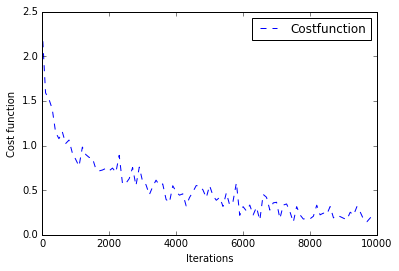

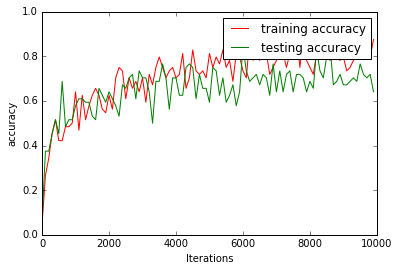

average training error 0.124523809524
average testing  error 0.293722943723


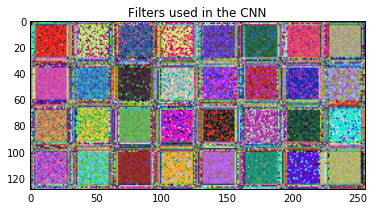

In [20]:
#Operations
learningrate = 0.001
ypred = tf.argmax(tf.nn.softmax(z),1)
cost = tf.nn.sparse_softmax_cross_entropy_with_logits(labels= y_,logits = z)
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
label = y_

trainaccuracy = []
testaccuracy = []
iterarray =[]
costarray=[]
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for iter in range(10000):
#x,yactual = batch(64)
        batch_list = np.random.randint(50000, size=64)
        sess.run(train_op, feed_dict={x_:train_x[batch_list,:,:,:], y_:train_y[batch_list]})
#sess.run(train_op,feed_dict={x_:x,y_:yactual})
        if (iter % 100 == 0):
            cost1 = np.mean(sess.run(cost, feed_dict={x_:train_x[batch_list,:,:,:], y_:train_y[batch_list]}))
            evaluation_list = np.random.randint(50000, size=64)
            tr_y = sess.run(y_, feed_dict={y_:train_y[evaluation_list]})
            train_pred = sess.run(ypred, feed_dict={x_:train_x[evaluation_list,:,:,:], y_:train_y[evaluation_list]})
            train_accuracy = Accuracy(train_pred, tr_y)
            trainaccuracy.append(train_accuracy)
            costarray.append(cost1)
            evaluation_list = np.random.randint(5000, size=64)
            te_y = sess.run(y_, feed_dict={y_:test_y[evaluation_list]})
            test_pred = sess.run(ypred, feed_dict={x_:test_x[evaluation_list,:,:,:], y_:test_y[evaluation_list]})
            test_accuracy = Accuracy(test_pred, te_y)
            testaccuracy.append(test_accuracy)
            iterarray.append(iter)
            if (iter%500 == 0 and iter!=0):
                learningrate = 0.9*learningrate
            
## PLotting the errors    
    plt.plot(iterarray,costarray,'b--',label='Costfunction')
    plt.xlabel('Iterations')
    plt.ylabel('Cost function')
    plt.legend()
    plt.show()
    
    plt.plot(iterarray,trainaccuracy, 'r-',label='training accuracy')
    plt.plot(iterarray,testaccuracy, 'g-',label='testing accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    
      
###############
    
    evaluation_list = np.random.randint(50000, size=64)
    tr_y = sess.run(y_, feed_dict={y_:train_y[evaluation_list]})
    train_p = sess.run(ypred, feed_dict={x_:train_x[evaluation_list,:,:,:], y_:train_y[evaluation_list]})
    trainerror = error(train_p, tr_y)
    avgtrainerror = numpy.mean(trainerror)
    print "average training error",avgtrainerror
    evaluation_list = np.random.randint(5000, size=64)
    te_y = sess.run(y_, feed_dict={y_:test_y[evaluation_list]})
    test_p = sess.run(ypred, feed_dict={x_:test_x[evaluation_list,:,:,:],y_:test_y[evaluation_list]})
    testerror = error(test_p, te_y)
    avgtesterror = numpy.mean(testerror)
    print "average testing  error",avgtesterror
    
##Visualizing the filters    
    channels = sess.run(layer1)
    for i in range(32):
        sess.run(tf.assign(Image,Image_noisy+100))
        sess.run(img_update, feed_dict={channel:np.expand_dims(channels[0:5,0:5,0:3,i],3)})
        filter1 = sess.run(Image)
        if i == 0:
            filters = filter1
        else:
            filters = np.vstack((filters, filter1))
    show_filters(np.transpose(filters,(1,2,3,0)))
    